Unique Labels: 2
Total Images: 849


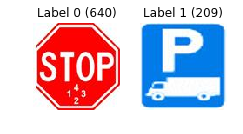

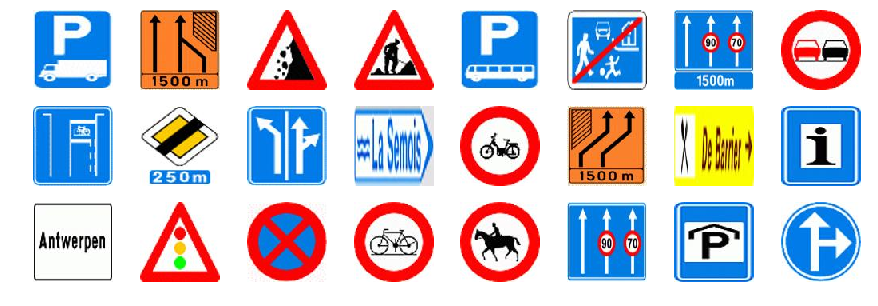

shape: (100, 100, 3), min: 0, max: 255
shape: (100, 100, 3), min: 0, max: 255
shape: (100, 100, 3), min: 0, max: 255
shape: (100, 100, 3), min: 0, max: 255
shape: (100, 100, 3), min: 0, max: 255


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


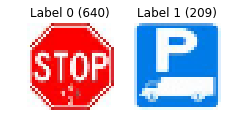

shape: (32, 32, 3), min: 0.0, max: 1.0
shape: (32, 32, 3), min: 0.0, max: 1.0
shape: (32, 32, 3), min: 0.0, max: 1.0
shape: (32, 32, 3), min: 0.0, max: 1.0
shape: (32, 32, 3), min: 0.0, max: 1.0
labels:  (849,) 
images:  (849, 32, 32, 3)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
images_flat:  Tensor("Flatten/Reshape:0", shape=(?, 2048), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)
Loss:  4.13728
Loss:  2.37317
Loss:  0.615683
Loss:  0.437732
Loss:  0.269082
Loss:  0.185406
Loss:  0.129276
Loss:  0.095236
Loss:  0.077546
Loss:  0.0628411
Loss:  0.0554774
Loss:  0.0480341
Loss:  0.0437329
Loss:  0.038144
Loss:  0.0345845
Loss:  0.0309568
Loss:  0.0293115
Loss:  0.0237753
Loss:  0.0233094
Loss:  0.021761
Loss:  0.020397
Loss:  0.0191152
Loss:  0.0162138
Loss:  0.0152079
Loss:  0.0143653
Loss:  0.0145309
Lo

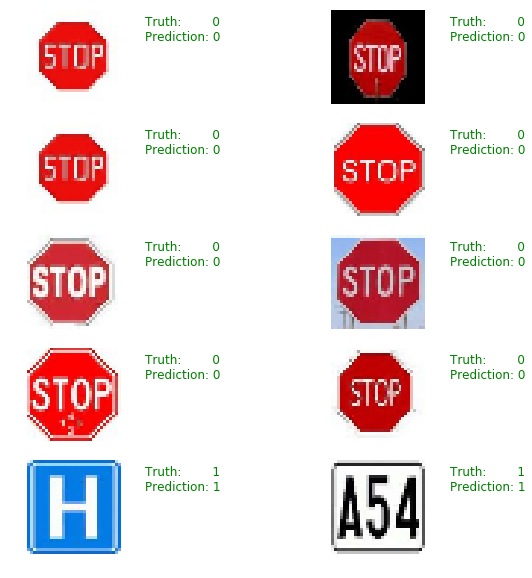

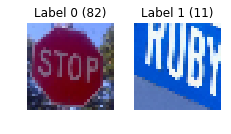

Accuracy: 0.989


In [3]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# Load Training dataset
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(".jpg")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels
train_data_dir = '/home/senlyu/git/Traffic_Sign_Detection/stop/Training'

images, labels = load_data(train_data_dir)

print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))


# Explore the training set
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)


def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 1)

# Resize images
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))
    
images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
display_images_and_labels(images32, labels)
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))
    

# Train
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    weight = tf.Variable(tf.truncated_normal([*conv_ksize, int(x_tensor.shape[3]), conv_num_outputs],stddev=0.01))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1,*conv_strides,1], padding='SAME')
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    conv_layer = tf.nn.relu(conv_layer)    
    conv_layer = tf.nn.max_pool(conv_layer, ksize=[1,*pool_strides,1], strides=[1,*pool_strides,1], padding='SAME')  
    
    return conv_layer




# Create a graph to hold the model.
graph = tf.Graph()
# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])
    keep_prob = 0.9
    
    # Apply cNN
    conv_1 = conv2d_maxpool(images_ph, 32, (3,3), (2,2), (2,2), (2,2))
    
    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(conv_1)

    # Apply dropout
    f_drop = tf.nn.dropout(images_flat, keep_prob)
    
    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(f_drop, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels_ph))
    #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels_ph))
    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    # TODO: rename to tf.global_variables_initializer() on TF 0.12.
    init = tf.initialize_all_variables()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

for i in range(801):
    _, loss_value = session.run(
        [train, loss],
        feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)
        
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])
    
    
# Test
# Load the test dataset.
test_data_dir = '/home/senlyu/git/Traffic_Sign_Detection/stop/testing/Testing'
test_images, test_labels = load_data(test_data_dir)
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32))
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

# Close the session. This will destroy the trained model.
session.close()
